In [1]:
#Some code has been modeled based on CISCO's Joy. 

In [2]:
import numpy as np
import pymongo
#from sklearn import neural_network
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split, cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer, log_loss, precision_score, f1_score, auc, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import sys
import math
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn import preprocessing
import matplotlib.pyplot as plt
from operator import add
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import pandas as pd
from scipy import stats
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import matplotlib.mlab as mlab
import socket
import pyasn
import csv
import subprocess

Function to send a folder to mongodb

In [3]:
def joy_to_mongo(ls, names):
    
    for n in names:
        try:
            mydb[n].drop()
        except Exception as e:
            pass
   
    btra = './bin/joy bidir=1 dist=1 '+ls[0]+'*.pcap | ./move2Cmongo/mongocpath '+names[0]
    btes = './bin/joy bidir=1 dist=1 '+ls[1]+'*.pcap | ./move2Cmongo/mongocpath '+names[1]
    ptra = './bin/joy bidir=1 dist=1 '+ls[2]+'*.pcap | ./move2Cmongo/mongocpath '+names[2]
    ptes = './bin/joy bidir=1 dist=1 '+ls[3]+'*.pcap | ./move2Cmongo/mongocpath '+names[3]
    
    print(''+ btra + '\n' + btes + '\n' + ptra + '\n' + ptes)
    
    subprocess.call(btra, shell=True)
    subprocess.call(btes, shell=True)
    subprocess.call(ptra, shell=True)
    subprocess.call(ptes, shell=True)
    
    return mydb[names[0]], mydb[names[1]], mydb[names[2]], mydb[names[3]]

## methods to gather data from flow

In [4]:
def getBD(doc, bd_s=None):
    data = []
    if len(doc['packets']) == 0:
        return
    if doc['byte_dist'] != None and sum(doc['byte_dist']) > 0:
        tmp = map(lambda x: x / float(sum(doc['byte_dist'])), doc['byte_dist'])
        data.extend(tmp)
        if (bd_s is not None):
            for i in range(len(tmp)):
                bd_s[i] += tmp[i]
        '''elif flag == 1:
            for i in range(len(tmp)):
                p_byte_dist_h[i] += tmp[i]'''
    else:
        data.extend(np.zeros(256))
    return data

In [5]:
def getIndividualPL(flow, pl_arr):
    transMat = np.zeros((numRows, numRows))
    if len(flow['packets']) == 0:
        return (list(transMat.flatten()))
    elif len(flow['packets']) == 1:
        curPacketSize = min(int(flow['packets'][0]['b'] / binSize), numRows - 1)
        transMat[curPacketSize, curPacketSize] = 1
        if (pl_arr is not None):
            pl_arr[curPacketSize, curPacketSize] += 1
        '''
        elif (flag == 1):
            p_pl[curPacketSize, curPacketSize] += 1
        '''
        return (list(transMat.flatten()))
        

    # get raw transition counts
    for i in range(1, len(flow['packets'])):
        prevPacketSize = min(int(flow['packets'][i - 1]['b'] / binSize), numRows - 1)
        if 'b' not in flow['packets'][i]:
            break
        curPacketSize = min(int(flow['packets'][i]['b'] / binSize), numRows - 1)
        transMat[prevPacketSize, curPacketSize] += 1
        
        if (pl_arr is not None):
            pl_arr[prevPacketSize, curPacketSize] += 1
        '''elif (flag == 1):
            p_pl[prevPacketSize, curPacketSize] += 1
        '''
    # get empirical transition probabilities
    for i in range(numRows):
        if float(np.sum(transMat[i:i + 1])) != 0:
            transMat[i:i + 1] = transMat[i:i + 1] / float(np.sum(transMat[i:i + 1]))

    return (list(transMat.flatten()))

In [6]:
def getIPT(flow, ipt_arr):
    #numRows = 10
    binSize = 50.0
    transMat = np.zeros((numRows, numRows))
    if len(flow['packets']) == 0:
        return (list(transMat.flatten()))
    elif len(flow['packets']) == 1:
        curIPT = min(int(flow['packets'][0]['ipt'] / float(binSize)), numRows - 1)
        transMat[curIPT, curIPT] = 1
        
        #for updating histograms/box charts
        if (ipt_arr is not None):
            ipt_arr[curIPT, curIPT] += 1
        '''elif (flag == 1):
            p_ipt_h[curIPT, curIPT] += 1'''
        return (list(transMat.flatten()))
        

    # get raw transition counts
    for i in range(1, len(flow['packets'])):
        prevIPT = min(int(flow['packets'][i - 1]['ipt'] / float(binSize)), numRows - 1)
        curIPT = min(int(flow['packets'][i]['ipt'] / float(binSize)), numRows - 1)
        transMat[prevIPT, curIPT] += 1
        
        if (ipt_arr is not None):
            ipt_arr[prevIPT, curIPT] += 1
        '''elif (flag == 1):
            p_ipt_h[prevIPT, curIPT] += 1
        '''
    # get empirical transition probabilities
    for i in range(numRows):
        if float(np.sum(transMat[i:i + 1])) != 0:
            transMat[i:i + 1] = transMat[i:i + 1] / float(np.sum(transMat[i:i + 1]))

    return (list(transMat.flatten()))

In [7]:
def getMD(flow):
    tmp = []

    if flow['dp'] != None:
        tmp.append(float(flow['dp']))  # destination port
    else:
        tmp.append(0)  # ICMP/etc.
    if flow['sp'] != None:
        tmp.append(float(flow['sp']))  # source port
    else:
        tmp.append(0)  # ICMP/etc.
    if 'num_pkts_in' in flow:
        tmp.append(flow['num_pkts_in'])  # inbound packets
    else:
        tmp.append(0)
    if 'num_pkts_out' in flow:
        tmp.append(flow['num_pkts_out'])  # outbound packets
    else:
        tmp.append(0)
    if 'bytes_in' in flow:
        tmp.append(flow['bytes_in'])  # inbound bytes
    else:
        tmp.append(0)
    if 'bytes_out' in flow:
        tmp.append(flow['bytes_out'])  # outbound bytes
    else:
        tmp.append(0)
    # elapsed time of flow
    if flow['packets'] == []:
        tmp.append(0)
    else:
        time = abs(flow['time_end'] - flow['time_start'])
        #for packet in flow['packets']:
        #    time += packet['ipt']
        tmp.append(time)
    return tmp

In [8]:
'''
use this to create the arrays to be used both to train/test on and to create graphs
Params:
Collection: the collection to loop through,
data_set: the variable that the collection doc's are appended to
label_set: is the set that is used to train/test with the data set (pass in None if 
            its not all benign or all pirated), 
label: 1 for pirate, 0 for benign.
cond: used to specifiy any conditions to search for in the collection
bd: set as 1 to include byte dist in data_set
ipt: set as 1 to include ipt in data set. 
pl: set as 1 to include packet lengths in data set
ips: pass in blank array to fill with ip tuples of flows

sp: pass in blank array to fill with source port #'s of flows
dp: pass in blank array to fill with dest port #'s of flows

byte_dist_h: blank array to fill out with byte distributions. Used to create graphs
ipt_tm: blank array to be filled with ipt tranisition matrix. Used to create graphs
pl_tm: blank array to be filled with pl transition matrix. Used to create graphs
NOTE: ipt_tm and pl_tm need to be passed in as an array with np.zeros((numRows, numRows)),
      while byte_dist_h needs to be an array of 0's with length 256
      
ipts_h: blank array to be filled with ipt's. Used to create graphs
pkt_size: blank array to be filled with packet sizes. Used to create graphs
flow_size: same as pkt_size except with flows
num_pkts: blank rray to be filled with number of packets. Used to create graphs
flow_time: blank array to be filled with flow times. Used to create graphs
'''
def set_up_array(collection, data_set, label_set=None, label=None, cond=None,
                bd=None, ipt=None, pl=None, ips=None, sp=None, dp=None,
                byte_dist_h=None, ipt_tm=None, pl_tm=None, ipts_h=None, pkt_size=None,
                flow_size=None, num_pkts=None, flow_time=None):
    for doc in collection.find(cond):
        tmpd = []
        tmp = getMD(doc)
        tmpb = getBD(doc, byte_dist_h)
        if (bd == 1 and (tmpb is None or len(tmpb) != 256)):
            tmpb = np.zeros(256)
        elif (bd == 1):
            tmpb = preprocessing.normalize([tmpb])
        tmpift = getIPT(doc, ipt_tm)

        #note: these 100's need to be changed if numRows is changed
        #if (tmpift is None or len(tmpift) != 100):
        #    continue

        tmpind_pl = getIndividualPL(doc, pl_tm)
        #if (tmpind_pl is None or len(tmpind_pl) != 100):
        #    continue
        
        #get ipt's and pkt_sizes for graph
        if(ipts_h != None):
            for pkt in doc['packets']:
                try:
                    ipts_h.append(pkt['ipt'])
                except Exception as e:
                    print e
                    pass
                if (pkt_size != None):
                    try:
                        pkt_size.append(pkt['b'])
                    except Exception as e:
                        print e
        elif(pkt_size != None):
            for pkt in doc['packets']:
                try:
                    pkt_size.append(pkt['b'])
                except Exception as e:
                    print e
        
        #get flow_size (number of bytes)
        #num bytes
        if (flow_size != None):
            try:
                flow_size.append(doc['bytes_in'] + doc['bytes_out'])
            except:
                try:
                    flow_size.append(doc['bytes_in'])
                except:
                    try:
                        flow_size.append(doc['bytes_out'])
                    except Exception as e:
                        print e
                        pass
            
        if (num_pkts != None):
            #num pkts
            try:
                num_pkts.append(doc['num_pkts_in'] + doc['num_pkts_out'])
            except:
                try:
                    num_pkts.append(doc['num_pkts_in'])
                except:
                    try:
                        num_pkts.append(doc['num_pkts_out'])
                    except Exception as e:
                        print e
                        pass
            
                    
            #flow duration
        if (flow_time != None):
            flow_time.append(tmp[6])
            
        
        if ips != None:
            ips.append((doc['sa'], doc['da']))
        
        
        if sp != None:
            sp.append(doc['sp'])
        if dp != None:
            dp.append(doc['dp'])
        tmpd.extend(tmp)
        if bd == 1:
            tmpd.extend(tmpb)
        if ipt == 1:
            tmpd.extend(tmpift)
        if pl == 1:
            tmpd.extend(tmpind_pl)
        data_set.append(tmpd)
        try:
            label_set.append(label)
        except Exception as e:
            pass
            #print('No label set given')

In [9]:
'''
This creates graphs based on the arrays pased in. To use the combine_graphs function,
use the output of this function. Note that the types of params used must match for both
data sets to use the combine_graphs function
Params:
    byte_dist_h: array of the byte distribution 
    ipt_tm: array of the ipt tranisiton matrix 
    pl_tm: array of the packet length transition matrix
    ipts_h: array of every flows ipt's 
    pkt_size: array of every flows' packet sizes )
    flow_size: array of every flow's size 
    num_pkts: array of every flow's number of packets
    flow_time: array of every flow's duration of time
    NOTE: all above values are obtained through the use of the function: set_up_array
    g_color: color used to 'paint' the graphs. Defaults to blue
    name_data: name of the type of data being graphed. Defaults to Benign
    
Outputs:
    tmp: an array that consists of the data used for all graphs. use this array to
        perform the combine_graphs function (note, you need one for both the 
        pirated and benign set to run combine_graphs)
    graph_nums: an array used to keep track of which graphs and data were inputted
'''
def graph_arrays(byte_dist_h=None, ipt_tm=None, pl_tm=None, ipts_h=None, pkt_size=None,
                 flow_size=None, num_pkts=None, flow_time=None, g_color='b', 
                 name_data='Benign'):
    tmp = []
    graph_nums = []
    if byte_dist_h is not None:
        y_pos = np.arange(len(byte_dist_h))
        x = preprocessing.normalize([byte_dist_h])
        plt.bar(y_pos, x[0], color=g_color)
        plt.title("Normalized " + name_data + " Byte Distribution")
        plt.show()
        tmp.append((x, y_pos))
        graph_nums.append(0)
        
    if ipt_tm is not None:
        ipt_h1 = ipt_tm.flatten().tolist()
        y_pos1 = np.arange(len(ipt_h1))
        x1 = preprocessing.normalize([ipt_h1])

        plt.bar(y_pos1, x1[0], color=g_color)
        plt.title(name_data + " IPT buckets")
        plt.show()
        tmp.append((x1, y_pos1))
        graph_nums.append(1)
        
    if pl_tm is not None:
        pl1 = pl_tm.flatten().tolist()
        y_pos2 = np.arange(len(pl1))
        x2 = preprocessing.normalize([pl1])
        plt.bar(y_pos2, x2[0], color=g_color)
        plt.title(name_data + ' PL Matrix')
        plt.show()
        tmp.append((x2, y_pos2))
        graph_nums.append(2)
        
    if ipts_h is not None:
        ipt2 = np.array([ipts_h])
        ipt2 = ipt2[abs(ipt2 - np.mean(ipt2)) < 3 * np.std(ipt2)]
        plt.hist(ipt2, weights=np.ones(len(ipt2))/len(ipt2), bins=10, range=(0,10), color=g_color)
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.xlabel('IPT Buckets')
        plt.ylabel('Percentage in Bucket')
        plt.title('Inter Packet Times: ' + name_data)
        plt.show()
        tmp.append(ipt2)
        graph_nums.append(3)
        
    if pkt_size is not None:
        b2 = np.array(pkt_size)
        #b2 = b2[abs(b2 - np.mean(b2)) < 3 * np.std(b2)]
        plt.hist(b2, weights=np.ones(len(b2))/len(b2), range=(0,2000), bins=40, color=g_color)
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.xlabel('Packet Size (bytes)')
        plt.ylabel('Percentage in Bucket')
        plt.title('Packet Sizes: ' + name_data)
    
        plt.show()
        tmp.append(b2)
        graph_nums.append(4)
        
    if flow_size is not None:
        flows2 = np.array(flow_size)
        flows2 = flows2[abs(flows2 - np.mean(flows2)) < 3 * np.std(flows2)]
        plt.hist(flows2, weights=np.ones(len(flows2))/len(flows2), range=(0,20000), bins=40, color=g_color)
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

        plt.xlabel('Flow Size (bytes)')
        plt.ylabel('Percentage in Bucket')
        plt.title('Flow Sizes: ' + name_data)
        plt.show()
        tmp.append(flows2)
        graph_nums.append(5)
        
    if num_pkts is not None:
        b_np = np.array(num_pkts)
        b_np = b_np[abs(b_np - np.mean(b_np)) < 3 * np.std(b_np)]
        plt.hist(b_np, weights=np.ones(len(b_np))/len(b_np), range=(0,12), bins=12, color=g_color)
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

        plt.xlabel('# Packets')
        plt.ylabel('Percentage in Bucket')
        plt.title('Number of Packets: ' + name_data)

        plt.show()
        tmp.append(b_np)
        graph_nums.append(6)
        
    if flow_time is not None:
        b_ft = np.array(flow_time)
        b_ft = b_ft[abs(b_ft - np.mean(b_ft)) < 3 * np.std(b_ft)]

        plt.hist(b_ft, weights=np.ones(len(b_ft))/len(b_ft), bins=10, range=(0, 10), color=g_color)


        plt.xlabel('Time Buckets (s)')
        plt.ylabel('Percentage in Bucket')
        plt.title('Flow Time: ' + name_data)
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

        plt.show()
        tmp.append(b_ft)
        graph_nums.append(7)
        
        
    return tmp, graph_nums

In [10]:
'''
Combines graph results created by graph_arrays. Takes in the output of 
graph_arrays for the benign dataset first, and then the results of the pirated
(Four params total, two for each set)
'''
def combine_graphs(benign_set, benign_nums, pirated_set, pirated_nums):
    if (len(benign_set) != len(pirated_set)):
        print('Different graphs were created in graph_arrays')
        return
    if benign_nums != pirated_nums:
        print('Different graphs were created in graph_arrays')
        return
    titles = ['Byte Distribution', 'Inter Packet Time Buckets', 'Packet Length Buckets',
             'Inter Packet Times', 'Packet Sizes', 'Flow Sizes', 'Number of Packets',
             'Flow Times']
    xlabels = ['Byte Value', 'Bucket', 'Bucket', 'Time (s)', 'Size (bytes)', 
              'Size (bytes)', 'Packets', 'Durations (s)']
    ranges = [None, None, None, (0, 10), (0, 2000), (0, 20000), (0,12), (0,10)]
    bins_x = [None, None, None, 10, 40, 40, 12, 10]
    for i in range(3):
        if (i in benign_nums):
            com = plt.subplot(111)
            benign_box = com.bar(benign_set[i][1], benign_set[i][0][0], color='b')
            pirate_box = com.bar(pirated_set[i][1], pirated_set[i][0][0], fc=(1, 0, 0, 0.5))
            com.legend((benign_box[0], pirate_box[0]), ('Benign', "Pirated"))
            plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
            com.set_ylabel('Percentage of All Flows')
            com.set_xlabel(xlabels[i])
            #com.title('Benign vs. Pirated Byte Distributions')
            plt.title(titles[0])
            plt.show()
    
    for i in range(3,8):
        if (i in benign_nums):
            com = plt.subplot(111)
            b_ = com.hist(benign_set[i], weights=np.ones(len(benign_set[i]))/len(benign_set[i]),
                                color='b', range=ranges[i], bins=bins_x[i])
            p_ = com.hist(pirated_set[i], weights=np.ones(len(pirated_set[i]))/len(pirated_set[i]),
                                color='r', range=ranges[i], bins=bins_x[i], fc=(1, 0, 0, 0.5))
            com.legend((b_[1], p_[1]), ('Benign', "Pirated"))
            com.set_ylabel('Percentage in Buckets')
            com.set_xlabel(xlabels[i])
            #com.title('Benign vs. Pirated Byte Distributions')
            plt.title(titles[i])
            plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
            plt.show()

In [11]:
'''
Scores a classifier with 6 metrics. 
Takes in a classifier, a true labelling of a test set, and the test set
Returns a list of scores in the order of:
    Accuracy
    Precision
    F1
    Logarithmic Loss
    True Positive Rate
    False Positive Rate
'''
metrics = [accuracy_score, precision_score, f1_score, log_loss]
def score_clf(clf, y_true, t_set):
    results = []
    #results.append(accuracy_score(y_true, y_pred))
    #results.append(precision_score(y_true, y_pred))
    y_pred = clf.predict(t_set)
    for metric in metrics:
        results.append(metric(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    #True Pos Rate = TP/FN+TP
    results.append(float(cm[0][0])/(cm[1][0] + cm[0][0]))
    #False Pos Rate = FP/FP+TN
    results.append(float(cm[0][1])/(cm[0][1]+cm[1][1]))
 
    return results

In [12]:
def bad_ip(fn_ip):
    if (fn_ip[0] == '192.168.5.113' or fn_ip[1] == '192.168.5.113' or 
        #fn_ip[0] == '192.168.5.157' or fn_ip[1] == '192.168.5.157' or
        fn_ip[0] == '192.168.5.151' or fn_ip[1] == '192.168.5.151'):
        return True

In [13]:
def ignore_ip(fn_ip):
    if (fn_ip[0] == '192.168.5.157' or fn_ip[1] == '192.168.5.157'):
        return True

In [14]:
def ignore_ports(sp, dp):
    if (sp == 443 or sp == 22 or sp == 53 or
        dp == 443 or dp == 22 or dp == 53):
        return True

In [15]:
'''
Function to get the name and cidr values of an IP address. 
Params:
    IP addr to find cidr and host of
    host_dict: dictionary mapping cidrs to host names
    new_hosts: dictionary to keep track of new mappings to add to a csv file
                that caches previously looked up host and host names
'''
def get_name_and_cidr(ip, host_dict, new_hosts):
    name = ''
    asn, cidr = asn_db.lookup(ip)
    if cidr in host_dict:
        return host_dict[cidr], cidr
    try:
        result = socket.gethostbyaddr(ip)
        name = result[0]
        asn = name.split('.')
        domain = asn[len(asn)-1]
        hoster = asn[len(asn)-2]
        name = hoster + '.' + domain
    except:
        name = cidr
    host_dict[cidr] = name
    new_hosts[cidr] = name
    return name, cidr

In [16]:
def get_pd(data, data_ips, data_b, data_sp, data_dp, clf_predict_proba, threshold=0.5):
    hosts = {}
    input_file = csv.reader(open('cidrs.csv'))
    for row in input_file:
        key = row[0]
        if key in hosts:
            pass
        hosts[key] = row[1]
    newhosts = {}
    
    pos_dat = []
    neg_dat = []
    count_pos = 0
    count_neg = 0
    
    for i in range(len(data)):
        #if bad_ip(fn_ips[i]):
        #    count_of_badip += 1
        #if ignore_ip(fn_ips[i]):
        #    continue
        if ignore_ports(data_sp[i], data_dp[i]):
            continue
        if data_b[i] <= 1:
            continue
        if clf_predict_proba[i][1] >= threshold:

            count_pos+=1

            s_name, s_cidr = get_name_and_cidr(data_ips[i][0], hosts, newhosts)
            d_name, d_cidr = get_name_and_cidr(data_ips[i][1], hosts, newhosts)

            pos_dat.append([data_ips[i][0], s_name, data_ips[i][1], d_name, 
                               clf_predict_proba[i][1], data_b[i]])
        else:
            count_neg+=1
            s_name, s_cidr = get_name_and_cidr(data_ips[i][0], hosts, newhosts)
            d_name, d_cidr = get_name_and_cidr(data_ips[i][1], hosts, newhosts)
            neg_dat.append([fn_ips[i][0], s_name, data_ips[i][1], d_name,
                               clf_predict_proba[i][1], data_b[i]])

    w = csv.writer(open('cidrs.csv', 'a'))
    for key, val in newhosts.items():
        w.writerow([key, val])
    
    pos_df = pd.DataFrame(pos_dat)
    neg_df = pd.DataFrame(neg_dat)
    pos_df.columns = ['Source IP', 'Source ASN','Dest IP', 'Dest ASN', 'Probability Pirated', 'Number of Bytes']
    neg_df.columns = ['Source IP', 'Source ASN','Dest IP', 'Dest ASN', 'Probability Pirated', 'Number of Bytes']
    return pos_df, neg_df, count_pos, count_neg

In [17]:
'''
Aggregates the dataframe passed in accross Host Names. Dataframe passed in 
should be created through the get_pd() method to avoid any errors
Returns aggregated dataframe object
'''
def agg_flow_df(flow_data_frame, file_name=None):
    f= {'Probability Pirated':'mean', 'Number of Bytes':'sum'}
    agg_ = flow_data_frame.groupby(['Dest ASN', 'Source ASN']).agg(f)
    if file_name is not None:
        agg_.to_csv(path_or_buf='~/'+file_name+'.csv')
    return agg_

In [18]:
''' Calculates and returns the bit rate given the bytes and duration of time
'''
def bit_rate(bts, ti):
    try:
        return float(bts * 8) / ti
    except Exception as e:
        return float(bts) * 8

In [19]:
'''
Gets the stats of a collection. 

Returns 6 Dataframe objects:
    1. full dataframe
    2. description of full dataframe (count of flows, means, standard deviations, etc)
    3. session dataframe
    4. description of session dataframe
    5. conversation dataframe
    6. description of conversation dataframe
Each dataframe is consisted of number of bytes, number of packets, duration of time and
bit rates. For session and conversation, the variables are summed across the
each session/conversation (num bytes, num pkts, and time are summed. Bit rate is recalculated)
'''
def get_stats(collection):
    hosts = {}
    input_file = csv.reader(open('cidrs.csv'))
    for row in input_file:
        key = row[0]
        if key in hosts:
            pass
        hosts[key] = row[1]
    newhosts = {}
    
    #array to turn into pd
    df_data = []
    #arrays to get info from collection
    data_a = []
    ip_a = []
    byte_a = []
    sp_a = []
    dp_a = []
    pkts_a = []
    time_a = []
    set_up_array(collection, data_a, ips=ip_a, flow_size=byte_a, sp=sp_a, dp=dp_a,
                num_pkts=pkts_a, flow_time=time_a)
    
    
    for i in range(len(data_a)):
        #if ignore_ports(sp_a[i], dp_a[i]):
        #    continue
        #if byte_a[i] <= 1:
        #    continue
        s_name, s_cidr = get_name_and_cidr(ip_a[i][0], hosts, newhosts)
        d_name, d_cidr = get_name_and_cidr(ip_a[i][1], hosts, newhosts)
        df_data.append([ip_a[i][0], s_name, ip_a[i][1], d_name, byte_a[i],
                       pkts_a[i], time_a[i]])
    df = pd.DataFrame(df_data)
    df.columns=['Source IP', 'Source ASN','Dest IP', 'Dest ASN', 'Number of Bytes', 'Number of Packets', 'Flow Duration']
    df['Bit Rate'] = df.apply(lambda x: bit_rate(x['Number of Bytes'], x['Flow Duration']), axis=1)
    sess_f= {'Number of Bytes':'sum', 'Flow Duration':'sum', 'Number of Packets':'sum',}
    session_df = df.groupby(['Source IP']).agg(sess_f)
    session_df['Bit Rate'] = session_df.apply(lambda x: bit_rate(x['Number of Bytes'], 
                                                                 x['Flow Duration']), axis=1)
    conv_df = df.groupby(['Source IP', 'Dest IP']).agg(sess_f)
    conv_df['Bit Rate'] = conv_df.apply(lambda x: bit_rate(x['Number of Bytes'], 
                                                           x['Flow Duration']), axis=1)    
    
    
    w = csv.writer(open('cidrs.csv', 'a'))
    for key, val in newhosts.items():
        w.writerow([key, val])
    
    return df, df.describe(), session_df, session_df.describe(), conv_df, conv_df.describe()
    

In [20]:
client = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = client["flowdb"]

#get an IPASN data file from Routeview to use and use pyasn to read it
asn_db = pyasn.pyasn('ipasn_db2.dat')


In [21]:
#Set to false if want to use already existing collections, true to run joy
question = False

In [22]:
if question:
    #'Note that this will clear all collections that are named in 'name_colls'
    #list
    b_tr = '~/btr/'
    b_te = '~/bte/'
    p_tr = '~/ptr/'
    p_te = '~/pte/'
    l = [b_tr, b_te, p_tr, p_te]
    name_colls = ['Benign_Train', 'Benign_Test', 'Pirate_Train', 'Pirate_Test']
    b_train_coll, b_test_coll, p_train_coll, p_test_coll = joy_to_mongo(l, name_colls)
    
else:
    #use already existing collections
    p_train_coll = mydb["p2"]
    p_test_coll = mydb["testP"]
    b_train_coll = mydb["b2"]
    b_test_coll = mydb["testB"]
    #net_train_coll = mydb["Netflow"]

## set up arrays using methods from above to be trained on

In [23]:
p_train = []
p_test = []
b_train = []
b_test = []
p_train_l = []
p_test_l = []
b_train_l = []
b_test_l = []


In [24]:
#these are for the individualPL 
numRows = 10
binSize = 150.0

b_byte_dist_h = [0] * 256
b_ipt_h = np.zeros((numRows, numRows))
p_byte_dist_h = [0] * 256
p_ipt_h = np.zeros((numRows, numRows))
b_pl = np.zeros((numRows,numRows))
p_pl = np.zeros((numRows,numRows))
b_ipts = []
p_ipts = []
b_pkt_size = []
p_pkt_size = []
b_flow_size = []
p_flow_size = []
b_num_pkts = []
p_num_pkts = []
b_flow_time = []
p_flow_time = []

In [25]:
#collection, data_set, label_set=None, label=None, chart=-1, cond=None, bd=None, ipt=None, pl=None
set_up_array(p_train_coll, p_train, p_train_l, 1, byte_dist_h=p_byte_dist_h, 
             ipt_tm=p_ipt_h, pl_tm=p_pl, ipts_h=p_ipts, pkt_size=p_pkt_size, 
             flow_size=p_flow_size, num_pkts=p_num_pkts, flow_time=p_flow_time)


set_up_array(p_test_coll, p_test, p_test_l, 1)

In [26]:
set_up_array(b_train_coll, b_train, b_train_l, 0, byte_dist_h=b_byte_dist_h, 
             ipt_tm=b_ipt_h, pl_tm=b_pl, ipts_h=b_ipts, pkt_size=b_pkt_size, 
             flow_size=b_flow_size, num_pkts=b_num_pkts, flow_time=b_flow_time)


set_up_array(b_test_coll, b_test, b_test_l, 0)

# Create Graphs

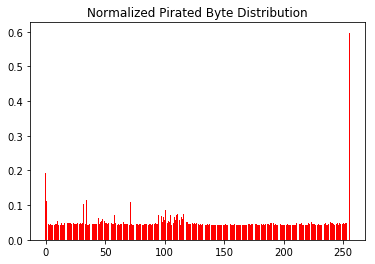

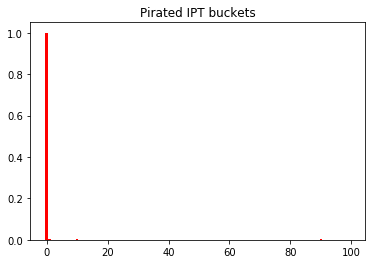

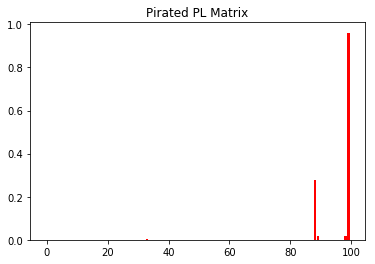

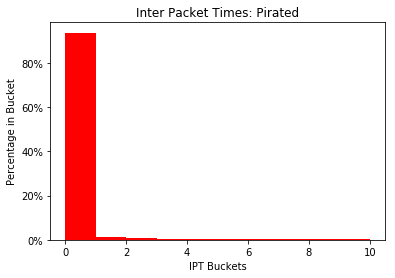

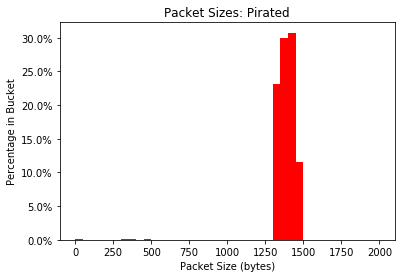

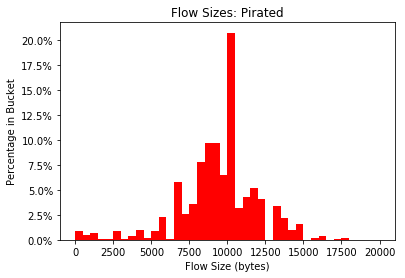

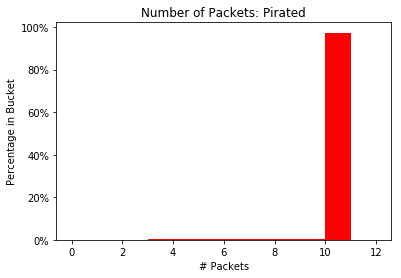

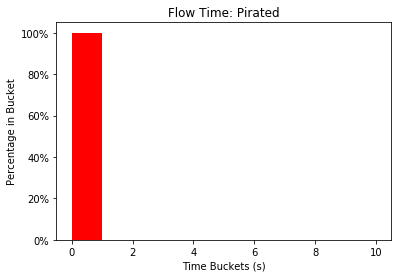

In [27]:
pirated_d, pirated_n = graph_arrays(byte_dist_h=p_byte_dist_h, ipt_tm=p_ipt_h, pl_tm=p_pl, ipts_h=p_ipts, 
             pkt_size=p_pkt_size, flow_size=p_flow_size, num_pkts=p_num_pkts, 
             flow_time=p_flow_time, g_color='r', name_data='Pirated')

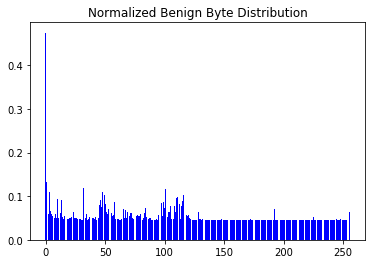

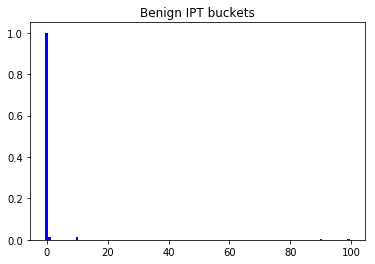

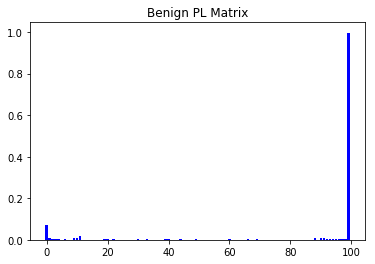

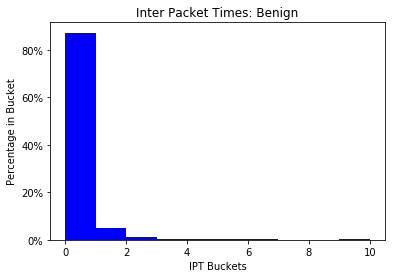

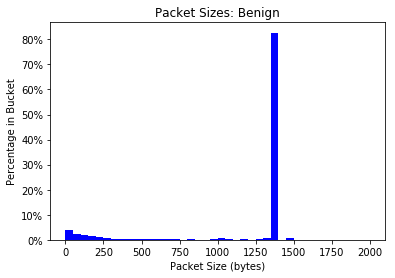

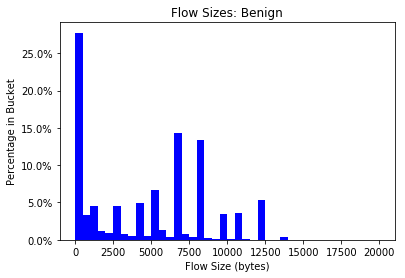

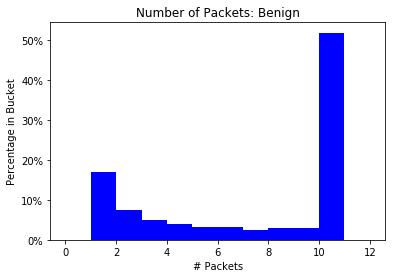

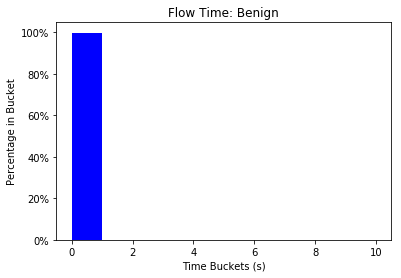

In [28]:
benign_d, benign_n = graph_arrays(byte_dist_h=b_byte_dist_h, ipt_tm=b_ipt_h, pl_tm=b_pl, ipts_h=b_ipts, 
             pkt_size=b_pkt_size, flow_size=b_flow_size, num_pkts=b_num_pkts, 
             flow_time=b_flow_time, g_color='b', name_data='Benign')

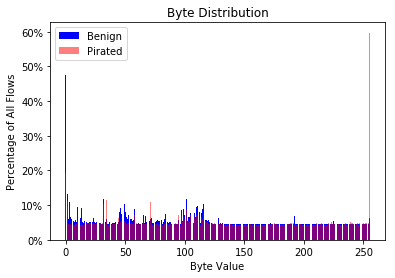

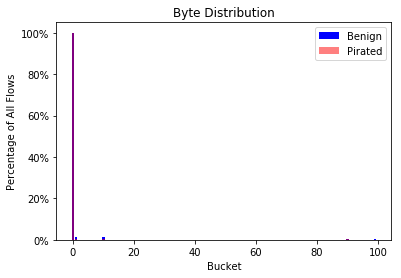

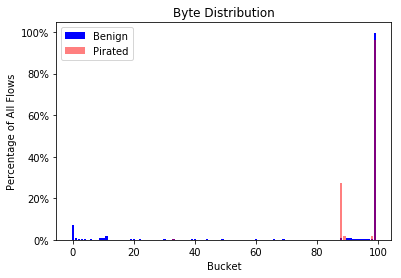

/home/thomasbelford/.local/lib/python2.7/site-packages/matplotlib/legend.py:937: UserWarning: Legend does not support array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]) instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


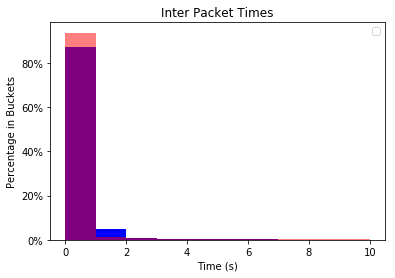

/home/thomasbelford/.local/lib/python2.7/site-packages/matplotlib/legend.py:937: UserWarning: Legend does not support array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
        450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
        900.,  950., 1000., 1050., 1100., 1150., 1200., 1250., 1300.,
       1350., 1400., 1450., 1500., 1550., 1600., 1650., 1700., 1750.,
       1800., 1850., 1900., 1950., 2000.]) instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


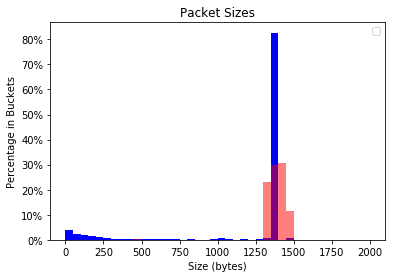

/home/thomasbelford/.local/lib/python2.7/site-packages/matplotlib/legend.py:937: UserWarning: Legend does not support array([    0.,   500.,  1000.,  1500.,  2000.,  2500.,  3000.,  3500.,
        4000.,  4500.,  5000.,  5500.,  6000.,  6500.,  7000.,  7500.,
        8000.,  8500.,  9000.,  9500., 10000., 10500., 11000., 11500.,
       12000., 12500., 13000., 13500., 14000., 14500., 15000., 15500.,
       16000., 16500., 17000., 17500., 18000., 18500., 19000., 19500.,
       20000.]) instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


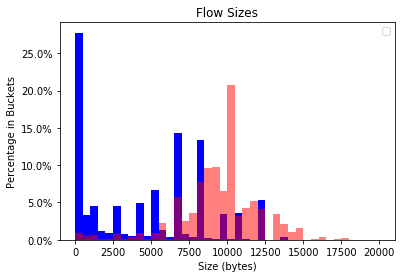

/home/thomasbelford/.local/lib/python2.7/site-packages/matplotlib/legend.py:937: UserWarning: Legend does not support array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]) instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


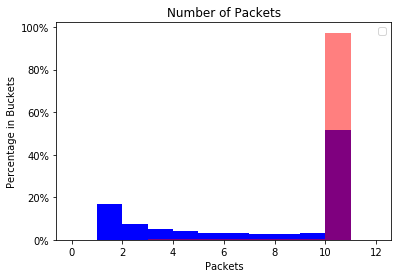

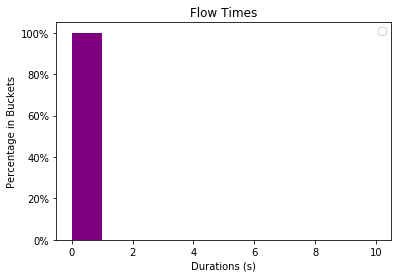

In [29]:
combine_graphs(benign_d, benign_n, pirated_d, pirated_n)

# Begin Machine Learning

Note: there are a few simple tests between here and the main tests below "Scoring"

In [30]:
training_set = []
training_set.extend(b_train)
training_set.extend(p_train)
training_labels = []
training_labels.extend(b_train_l)
training_labels.extend(p_train_l)
training_set = np.array(training_set)
training_labels = np.array(training_labels)
b_train = np.array(b_train)
p_train = np.array(p_train)
b_train_l = np.array(b_train_l)
p_train_l = np.array(p_train_l)

In [31]:
test_set = []
test_labels = []
test_set.extend(b_test)
test_set.extend(p_test)
test_labels.extend(b_test_l)
test_labels.extend(p_test_l)
test_set = np.array(test_set)
test_labels = np.array(test_labels)
b_test = np.array(b_test)
p_test = np.array(p_test)
b_test_l = np.array(b_test_l)
p_test_l = np.array(p_test_l)

In [32]:
logreg = LogisticRegression()
logreg.fit(training_set, training_labels)
print(logreg.score(test_set, test_labels))
print(logreg.score(b_test, b_test_l))
print(logreg.score(p_test, p_test_l))

/home/thomasbelford/.local/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7640059937825688
0.8166023166023166
0.7607720247845595


In [33]:
print(logreg.score(training_set, training_labels))

0.7630680402702267


In [34]:
dt = DecisionTreeClassifier(criterion='gini')
dt.fit(training_set, training_labels)
print(dt.score(test_set, test_labels))
print(dt.score(b_test, b_test_l))
print(dt.score(p_test, p_test_l))

0.8862970500749223
0.9447876447876448
0.8827006623459868


In [35]:
#all benign test
ab_test_coll = mydb["bWeb"]
ab_test = []
ab_l = []
ab_s_ip = []
#ab_d_ip = []

set_up_array(ab_test_coll, ab_test, ab_l, 0, ips=ab_s_ip)


In [36]:
print(dt.score(ab_test, ab_l))

0.7851851851851852


In [37]:
rf = RandomForestClassifier(bootstrap=False)
rf.fit(training_set, training_labels)

/home/thomasbelford/.local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [38]:
print(rf.score(test_set, test_labels))
print(rf.score(b_test, b_test_l))
print(rf.score(p_test, p_test_l))
#print(rf.score(n_test, n_l))
print(rf.score(ab_test, ab_l))

0.8917764408561268
0.967953667953668
0.8870925622581488
0.7555555555555555


In [39]:
probs = rf.predict_proba(ab_test)

# Scoring

In [40]:
log_reg = LogisticRegression()
log_reg.fit(training_set, training_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [41]:
d_tree = DecisionTreeClassifier()
d_tree.fit(training_set, training_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [42]:
rand_forest = rf #RandomForestClassifier()
#rand_forest.fit(training_set, training_labels)

In [43]:
res=[]
clfs = [log_reg, d_tree, rand_forest] #dt_boost]#, boosterRF]
for clf in clfs:
    res.append(score_clf(clf, test_labels, test_set))
clf_names = ['LR:','DT:', 'RF:']#, 'BoostDT:']#, 'BoostRF:']

In [44]:
score_df = pd.DataFrame(res)
score_df.columns = ['Accuracy', 'Precision', 'F1', 'Log_Loss', 'TruePosRate', 'FalsePosRate']
score_df.index = clf_names

In [45]:
score_df

,Accuracy,Precision,F1,Log_Loss,TruePosRate,FalsePosRate
LR:,0.764006,0.985394,0.858636,8.150953,0.173474,0.014606
DT:,0.898531,0.995962,0.943298,3.504631,0.357279,0.004038
RF:,0.891776,0.997784,0.939188,3.737911,0.345174,0.002216


In [46]:
FullNet_c = mydb['mediacom2']
fnc = []
fn_ips = []
fnb = []
spm = []
dpm = []
set_up_array(FullNet_c, fnc, ips=fn_ips, flow_size=fnb, sp=spm, dp=dpm)

In [47]:
prob_fnc = rand_forest.predict_proba(fnc)

In [48]:
pirate_pd, benign_pd, count_p, count_b = get_pd(fnc, fn_ips, fnb, spm, dpm, prob_fnc, 0.8)

In [49]:
agg_pd = agg_flow_df(pirate_pd, 'mediacom2')
agg_bd = agg_flow_df(benign_pd, 'mediacom2benign')

In [50]:
agg_pd

,,Number of Bytes,Probability Pirated
Dest ASN,Source ASN,,
104.156.240.0/21,mchsi.com,63306,0.800000
104.240.0.0/16,mchsi.com,34329,0.800000
104.244.227.0/24,mchsi.com,65079,0.800000
104.255.232.0/23,mchsi.com,78326,0.800000
107.6.96.0/21,mchsi.com,54476,0.800000
108.177.112.0/24,mchsi.com,364,0.800000
108.61.108.0/22,mchsi.com,6914,0.800000
113.250.0.0/15,mchsi.com,18703,0.900000
115.135.128.0/18,mchsi.com,41233,0.900000


In [51]:
agg_bd

,,Number of Bytes,Probability Pirated
Dest ASN,Source ASN,,
0.0,mchsi.com,2076352,0.289286
1.56.0.0/13,mchsi.com,27409,0.600000
100.42.105.0/24,mchsi.com,57555,0.200000
100.42.17.0/24,mchsi.com,37870,0.250000
103.104.16.0/23,mchsi.com,46980,0.400000
103.193.80.0/22,mchsi.com,20235,0.300000
103.224.251.0/24,mchsi.com,119942,0.550000
103.24.15.0/24,mchsi.com,9443,0.500000
103.251.109.0/24,mchsi.com,63673,0.000000


In [52]:
b_byte_total = agg_bd['Number of Bytes'].sum()
p_byte_total = agg_pd['Number of Bytes'].sum()

In [53]:
print b_byte_total
print p_byte_total

2262771477
263368557


In [54]:
comb = b_byte_total + p_byte_total
print float(b_byte_total) / comb
print float(p_byte_total) / comb

0.89574269302
0.10425730698


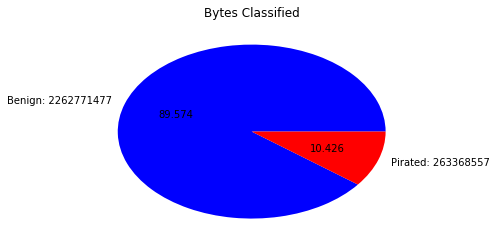

In [55]:
values = [b_byte_total, p_byte_total]
plt.pie(values, colors=['b', 'r'], labels=['Benign: ' + str(b_byte_total), 'Pirated: ' + str(p_byte_total)], autopct='%.3f')
plt.title('Bytes Classified')
plt.show()

# Get Stats of a Collection

In [56]:
tdf, tdfd, tsdf, tsdfd, tcdf, tcdfd = get_stats(b_test_coll)


/home/thomasbelford/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/home/thomasbelford/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


In [57]:
tdfd #all flows

,Number of Bytes,Number of Packets,Flow Duration,Bit Rate
count,2590.000000,2590.000000,2590.000000,2.590000e+03
mean,5410.860618,14.288417,0.625980,1.776584e+08
std,7245.057891,33.431675,3.076489,1.201749e+09
min,0.000000,1.000000,0.000000,0.000000e+00
25%,140.250000,5.000000,0.000313,1.455835e+04
50%,4819.500000,10.000000,0.000570,3.447433e+07
75%,7718.750000,10.000000,0.002549,1.054532e+08
max,115711.000000,462.000000,36.776162,2.295123e+10


In [58]:
tsdfd #sessions, aggregate over source ip

,Number of Packets,Number of Bytes,Flow Duration,Bit Rate
count,20.000000,2.000000e+01,20.000000,1.800000e+01
mean,1850.350000,7.007064e+05,81.064468,2.649609e+05
std,4747.727204,1.687235e+06,258.788768,8.916215e+05
min,1.000000,0.000000e+00,0.000000,3.784425e+01
25%,10.250000,1.310000e+02,0.199611,1.203145e+03
50%,20.000000,1.998000e+03,4.268054,6.187486e+03
75%,261.000000,3.825450e+04,57.892324,7.164418e+04
max,18840.000000,4.943247e+06,1169.991178,3.814234e+06


In [59]:
tcdfd #conversations, aggregate over combination of source and dest ip

,Number of Packets,Number of Bytes,Flow Duration,Bit Rate
count,181.000000,1.810000e+02,181.000000,1.690000e+02
mean,204.458564,7.742613e+04,8.957400,inf
std,811.242473,4.968992e+05,17.933515,NaN
min,1.000000,0.000000e+00,0.000000,3.784425e+01
25%,24.000000,4.725000e+03,0.128622,1.880810e+04
50%,50.000000,1.099600e+04,0.930688,9.781671e+04
75%,156.000000,3.009200e+04,10.059792,4.366929e+05
max,8163.000000,4.943247e+06,104.997799,inf


In [60]:
print tdf['Flow Duration'].sum()


1621.2893602848053


# Open VPN stuff

In [61]:
vpn_c = mydb['WithVPN']
n_vpn_c = mydb['NoVPN']

In [62]:
vpn_set = []
vpn_labels = []
n_vpn_set = []
n_vpn_labels = []
bv = [0] * 256
bnv = [0] * 256

In [63]:
set_up_array(vpn_c, vpn_set, vpn_labels, 1)
set_up_array(n_vpn_c, n_vpn_set, n_vpn_labels, 0)

In [64]:
set_of_both = []
labels_of_both = []

In [65]:
set_of_both.extend(vpn_set)
set_of_both.extend(n_vpn_set)
labels_of_both.extend(vpn_labels)
labels_of_both.extend(n_vpn_labels)

In [66]:
train_arr, test_arr, train_l, test_l = train_test_split(set_of_both, labels_of_both, test_size=0.2)

In [67]:
cross_val = cross_validate(RandomForestClassifier(), set_of_both, labels_of_both, cv=StratifiedKFold(5, True), )

In [68]:
cs = pd.DataFrame(cross_val)
cs

/home/thomasbelford/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,fit_time,score_time,test_score,train_score
0,0.055878,0.003322,0.816092,0.972622
1,0.051943,0.003261,0.827586,0.976945
2,0.050592,0.003257,0.821839,0.976945
3,0.051280,0.003193,0.729885,0.979827
4,0.050895,0.003039,0.796512,0.979885


In [69]:
rf3 = RandomForestClassifier()
rf3.fit(train_arr, train_l)
print rf.score(test_arr, test_l)
cf = rf.predict(test_arr)
cm = confusion_matrix(test_l, cf)
cm

0.6609195402298851


array([[104,  32],
       [ 27,  11]])

In [70]:
test_p_level = []
#all are benign
for i in range(len(labels_of_both)):
    if i == 1:
        test_p_level.append(1)
    else:
        test_p_level.append(0)

In [71]:
x = score_clf(rand_forest, test_p_level, set_of_both)
dfx = pd.DataFrame(x).T
dfx.columns = ['Accuracy', 'Precision', 'F1', 'Log_Loss', 'TruePosRate', 'FalsePosRate']

In [72]:
dfx

,Accuracy,Precision,F1,Log_Loss,TruePosRate,FalsePosRate
0,0.751152,0.0,0.0,8.595101,0.998469,1.0
